# Fetal Movement Detection Project
Complete end-to-end analysis with ML (Random Forest) and DL (BiLSTM) models

## 1. Library Installation

In [ ]:
# Install required libraries
!pip install numpy pandas scipy matplotlib seaborn scikit-learn imbalanced-learn tensorflow keras

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, auc,
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print('All libraries imported successfully!')

All libraries imported successfully!


## 3. Data Loading

In [2]:
# Define data folder path
data_folder = 'data'

# Get all mat files
mat_files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]
signal_files = sorted([f for f in mat_files if '_signal' in f])
bp_files = sorted([f for f in mat_files if '_bp' in f])

print(f'Found {len(signal_files)} signal files')
print(f'Found {len(bp_files)} BP (label) files')
print('\nSignal files:', signal_files[:3], '...')
print('BP files:', bp_files[:3], '...')

Found 16 signal files
Found 16 BP (label) files

Signal files: ['154100_signal.mat', '450569_signal.mat', '450663_signal.mat'] ...
BP files: ['154100_bp.mat', '450569_bp.mat', '450663_bp.mat'] ...


In [3]:
# Load and inspect first signal file
sample_signal = sio.loadmat(os.path.join(data_folder, signal_files[0]))
print('Signal file keys:', [k for k in sample_signal.keys() if not k.startswith('__')])
for k, v in sample_signal.items():
    if not k.startswith('__'):
        print(f'  {k}: shape={v.shape}, dtype={v.dtype}')

print('\n--- BP File ---')
sample_bp = sio.loadmat(os.path.join(data_folder, bp_files[0]))
print('BP file keys:', [k for k in sample_bp.keys() if not k.startswith('__')])
for k, v in sample_bp.items():
    if not k.startswith('__'):
        print(f'  {k}: shape={v.shape}, dtype={v.dtype}')

Signal file keys: ['BCG_PREPROC_3AXIS']
  BCG_PREPROC_3AXIS: shape=(154099, 3), dtype=float64

--- BP File ---
BP file keys: ['BP_MOUV_FILES']
  BP_MOUV_FILES: shape=(154100, 1), dtype=uint8


In [4]:
# Load all data
all_signals = []
all_labels = []

for sig_file, bp_file in zip(signal_files, bp_files):
    # Load signal data
    sig_data = sio.loadmat(os.path.join(data_folder, sig_file))
    sig_key = [k for k in sig_data.keys() if not k.startswith('__')][0]
    signal = sig_data[sig_key]
    
    # Load BP/label data
    bp_data = sio.loadmat(os.path.join(data_folder, bp_file))
    bp_key = [k for k in bp_data.keys() if not k.startswith('__')][0]
    bp = bp_data[bp_key]
    
    all_signals.append(signal)
    all_labels.append(bp)
    
print(f'Loaded {len(all_signals)} signal recordings')
print(f'First signal shape: {all_signals[0].shape}')
print(f'First BP shape: {all_labels[0].shape}')

Loaded 16 signal recordings
First signal shape: (154099, 3)
First BP shape: (154100, 1)


In [5]:
# Create DataFrame from first subject for initial exploration
signal_df = pd.DataFrame(all_signals[0], columns=['X', 'Y', 'Z'] if all_signals[0].shape[1]==3 else [f'Ch{i}' for i in range(all_signals[0].shape[1])])
print('First few rows of signal data:')
signal_df.head(10)

First few rows of signal data:


,X,Y,Z
0,-11.118712,-10.677463,-16.522648
1,-11.119985,-10.676691,-16.522555
2,-11.120747,-10.679731,-16.525141
3,-11.122699,-10.682313,-16.522991
4,-11.123805,-10.683450,-16.521847
5,-11.124573,-10.682667,-16.520459
6,-11.126029,-10.684466,-16.521586
7,-11.128150,-10.686215,-16.522230
8,-11.128168,-10.687588,-16.520055
9,-11.128518,-10.690159,-16.517763


In [6]:
# Check for missing values
print('Missing values in signal data:')
print(signal_df.isnull().sum())
print(f'\nTotal missing values: {signal_df.isnull().sum().sum()}')

# Handle missing values if any
if signal_df.isnull().sum().sum() > 0:
    signal_df = signal_df.fillna(method='ffill').fillna(method='bfill')
    print('Missing values handled using forward/backward fill')
else:
    print('No missing values found!')

Missing values in signal data:
X    0
Y    0
Z    0
dtype: int64

Total missing values: 0
No missing values found!


## 4. Data Preparation with Sliding Window

In [7]:
# Sliding window segmentation function
def create_windows(signal, labels, window_size=500, step=250):
    """Create sliding windows with labels.
    window_size=500 samples = 1 second at 500Hz
    step=250 = 50% overlap
    """
    X_windows = []
    y_windows = []
    
    # Flatten labels if needed
    if len(labels.shape) > 1:
        labels = labels.flatten()
    
    n_samples = min(len(signal), len(labels))
    
    for i in range(0, n_samples - window_size, step):
        window = signal[i:i+window_size]
        # Label = 1 if any movement in window, else 0
        label = 1 if np.any(labels[i:i+window_size] > 0) else 0
        X_windows.append(window)
        y_windows.append(label)
    
    return np.array(X_windows), np.array(y_windows)

print('Sliding window function created')

Sliding window function created


In [8]:
# Process all subjects with sliding windows
WINDOW_SIZE = 500  # 1 second
STEP = 250  # 50% overlap

X_all = []
y_all = []

for i, (signal, labels) in enumerate(zip(all_signals, all_labels)):
    X_win, y_win = create_windows(signal, labels, WINDOW_SIZE, STEP)
    X_all.append(X_win)
    y_all.append(y_win)
    print(f'Subject {i+1}: {X_win.shape[0]} windows')

# Combine all subjects
X = np.vstack(X_all)
y = np.concatenate(y_all)

print(f'\nTotal windows: {X.shape[0]}')
print(f'Window shape: {X.shape[1:]} (timesteps, features)')
print(f'Labels shape: {y.shape}')

Subject 1: 615 windows
Subject 2: 1801 windows
Subject 3: 1801 windows
Subject 4: 1803 windows
Subject 5: 1803 windows
Subject 6: 1804 windows
Subject 7: 1804 windows
Subject 8: 1804 windows
Subject 9: 1805 windows
Subject 10: 1805 windows
Subject 11: 1805 windows
Subject 12: 1806 windows
Subject 13: 1806 windows
Subject 14: 1806 windows
Subject 15: 1806 windows
Subject 16: 1806 windows

Total windows: 27680
Window shape: (500, 3) (timesteps, features)
Labels shape: (27680,)


## 5. Check Data Balance

Class Distribution:
  Class 0 (No Movement): 26234 samples (94.78%)
  Class 1 (Movement): 1446 samples (5.22%)


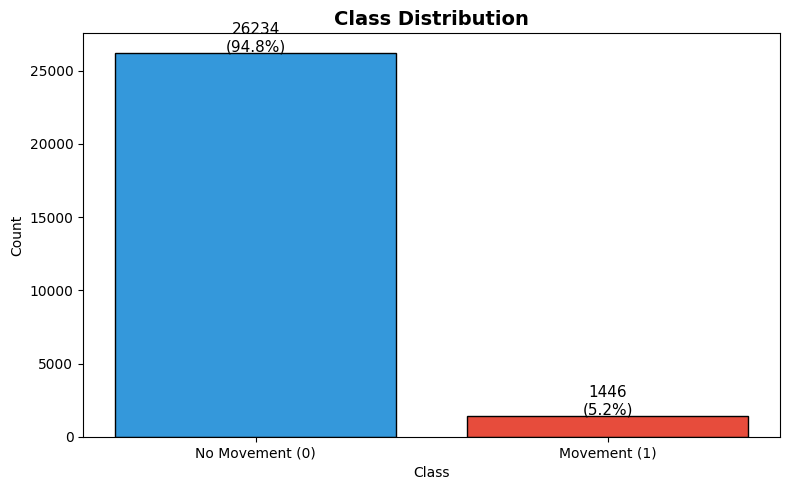


Imbalance ratio: 18.14
Dataset is IMBALANCED


In [9]:
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print('Class Distribution:')
for u, c in zip(unique, counts):
    label_name = 'Movement' if u == 1 else 'No Movement'
    print(f'  Class {u} ({label_name}): {c} samples ({c/len(y)*100:.2f}%)')

# Visualize class imbalance
plt.figure(figsize=(8, 5))
colors = ['#3498db', '#e74c3c']
plt.bar(['No Movement (0)', 'Movement (1)'], counts, color=colors, edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, (u, c) in enumerate(zip(unique, counts)):
    plt.text(i, c + 50, f'{c}\n({c/len(y)*100:.1f}%)', ha='center', fontsize=11)
plt.tight_layout()
plt.show()

# Check if imbalanced (ratio > 1.5)
imbalance_ratio = max(counts) / min(counts)
print(f'\nImbalance ratio: {imbalance_ratio:.2f}')
is_imbalanced = imbalance_ratio > 1.5
print(f'Dataset is {"IMBALANCED" if is_imbalanced else "BALANCED"}')

In [10]:
# Apply SMOTE if imbalanced
# Flatten X for SMOTE (needs 2D input)
X_flat = X.reshape(X.shape[0], -1)

if is_imbalanced:
    print('Applying SMOTE to balance the dataset...')
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_flat, y)
    print(f'Before SMOTE: {len(y)} samples')
    print(f'After SMOTE: {len(y_balanced)} samples')
    
    # Show new distribution
    unique_new, counts_new = np.unique(y_balanced, return_counts=True)
    print('\nNew Class Distribution:')
    for u, c in zip(unique_new, counts_new):
        print(f'  Class {u}: {c} samples ({c/len(y_balanced)*100:.2f}%)')
else:
    X_balanced, y_balanced = X_flat, y
    print('Dataset is balanced, no SMOTE needed')

Applying SMOTE to balance the dataset...
Before SMOTE: 27680 samples
After SMOTE: 52468 samples

New Class Distribution:
  Class 0: 26234 samples (50.00%)
  Class 1: 26234 samples (50.00%)


## 6. Exploratory Data Analysis (EDA)

In [11]:
# EDA Step 1: Dataset Overview
print('='*50)
print('DATASET OVERVIEW')
print('='*50)
print(f'Total samples: {len(y_balanced)}')
print(f'Features per sample: {X_balanced.shape[1]}')
print(f'Window size: {WINDOW_SIZE} samples (1 second at 500Hz)')
print(f'Number of subjects: {len(all_signals)}')
print(f'Sampling frequency: 500 Hz')

DATASET OVERVIEW
Total samples: 52468
Features per sample: 1500
Window size: 500 samples (1 second at 500Hz)
Number of subjects: 16
Sampling frequency: 500 Hz


In [12]:
# EDA Step 2: Statistical Summary
print('STATISTICAL SUMMARY')
print('='*50)
stats_df = pd.DataFrame(X_balanced)
summary = stats_df.describe().T
print(summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].head(20))
print('\n(Showing first 20 features...)')

STATISTICAL SUMMARY
         mean       std        min        25%        50%        75%        max
0  -10.966477  1.238567 -26.752179 -11.759166 -11.131991  -9.850742   0.441102
1  -10.529706  0.826591 -12.271726 -10.940455 -10.578079 -10.200723   0.708160
2  -16.222108  0.295265 -16.834532 -16.425304 -16.297939 -16.192070  -0.071958
3  -10.966768  1.238179 -29.062180 -11.759022 -11.132470  -9.850841  -7.974065
4  -10.529939  0.825042 -14.071424 -10.940501 -10.577696 -10.201104  -8.309227
5  -16.222285  0.290487 -16.871300 -16.425276 -16.298072 -16.192369  -4.928202
6  -10.966437  1.235590 -13.905910 -11.759409 -11.131914  -9.850942  -7.971715
7  -10.529813  0.824960 -12.270374 -10.940153 -10.577709 -10.200534  -8.310146
8  -16.222341  0.286253 -16.907313 -16.424802 -16.297850 -16.192126 -15.141589
9  -10.966052  1.238258 -13.907362 -11.760136 -11.132241  -9.851182   7.928857
10 -10.529921  0.825035 -13.891648 -10.939955 -10.577729 -10.202350  -8.310085
11 -16.221841  0.307871 -16.9547

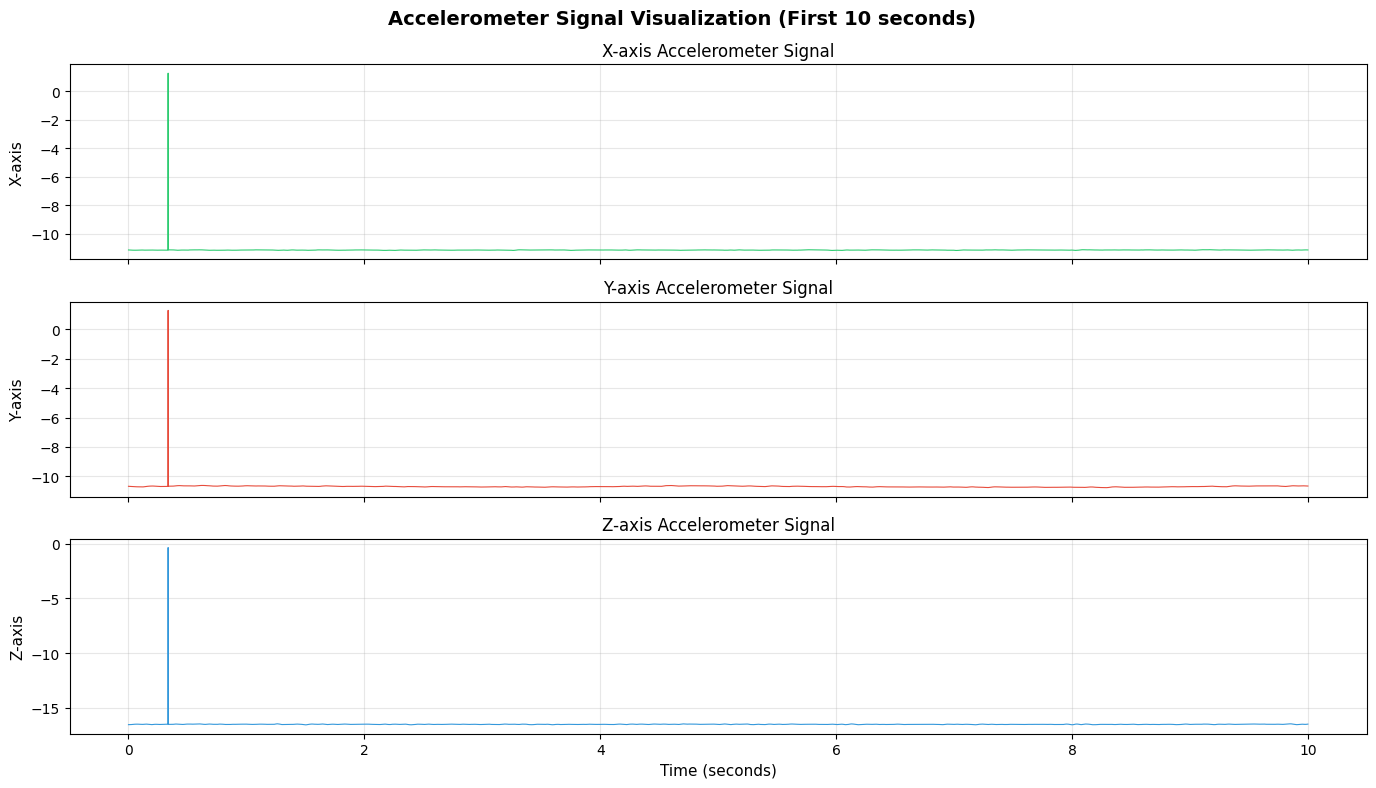

In [13]:
# EDA Step 3: Signal Visualization (Sample from first subject)
sample_signal = all_signals[0][:5000]  # First 10 seconds
time = np.arange(len(sample_signal)) / 500  # Convert to seconds

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
colors = ['#2ecc71', '#e74c3c', '#3498db']
labels = ['X-axis', 'Y-axis', 'Z-axis']

for i, (ax, color, label) in enumerate(zip(axes, colors, labels)):
    if sample_signal.shape[1] > i:
        ax.plot(time, sample_signal[:, i], color=color, linewidth=0.8)
        ax.set_ylabel(label, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{label} Accelerometer Signal', fontsize=12)

axes[-1].set_xlabel('Time (seconds)', fontsize=11)
plt.suptitle('Accelerometer Signal Visualization (First 10 seconds)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

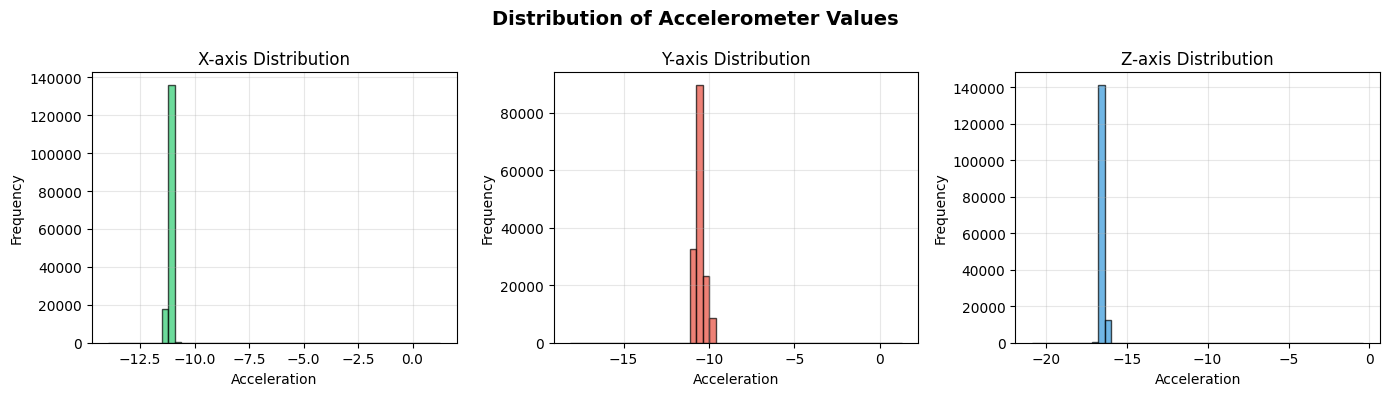

In [14]:
# EDA Step 4: Distribution of Accelerometer Values
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
colors = ['#2ecc71', '#e74c3c', '#3498db']
labels = ['X-axis', 'Y-axis', 'Z-axis']

for i, (ax, color, label) in enumerate(zip(axes, colors, labels)):
    if all_signals[0].shape[1] > i:
        ax.hist(all_signals[0][:, i], bins=50, color=color, alpha=0.7, edgecolor='black')
        ax.set_title(f'{label} Distribution', fontsize=12)
        ax.set_xlabel('Acceleration')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

plt.suptitle('Distribution of Accelerometer Values', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

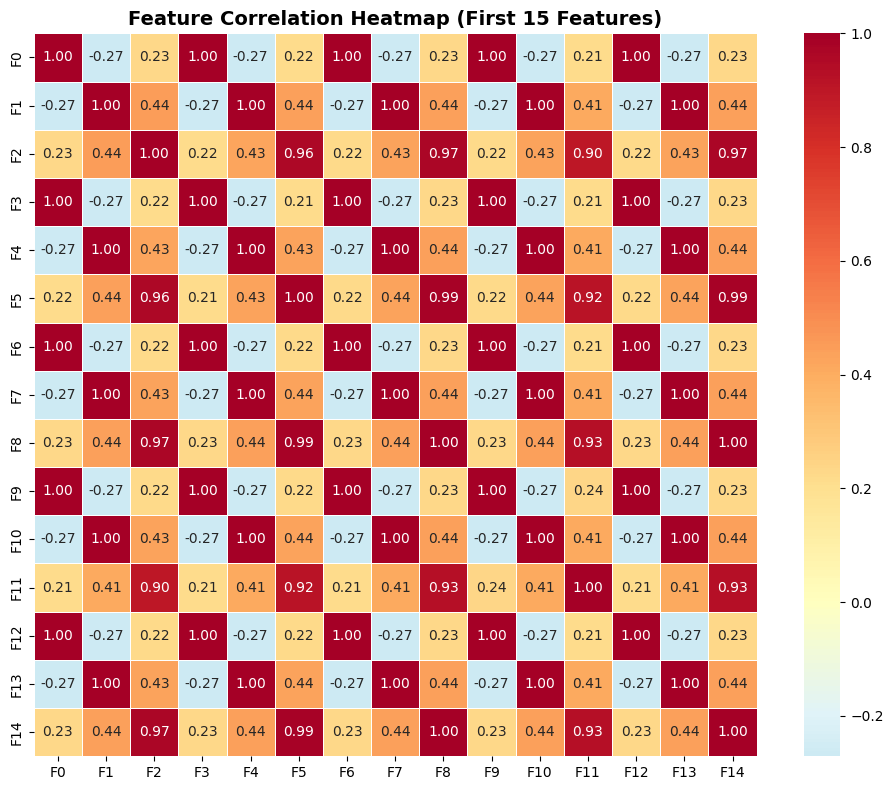

In [15]:
# EDA Step 5: Correlation Analysis
# Take sample features for correlation
sample_features = pd.DataFrame(X_balanced[:, :15], columns=[f'F{i}' for i in range(15)])

plt.figure(figsize=(10, 8))
corr_matrix = sample_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap (First 15 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

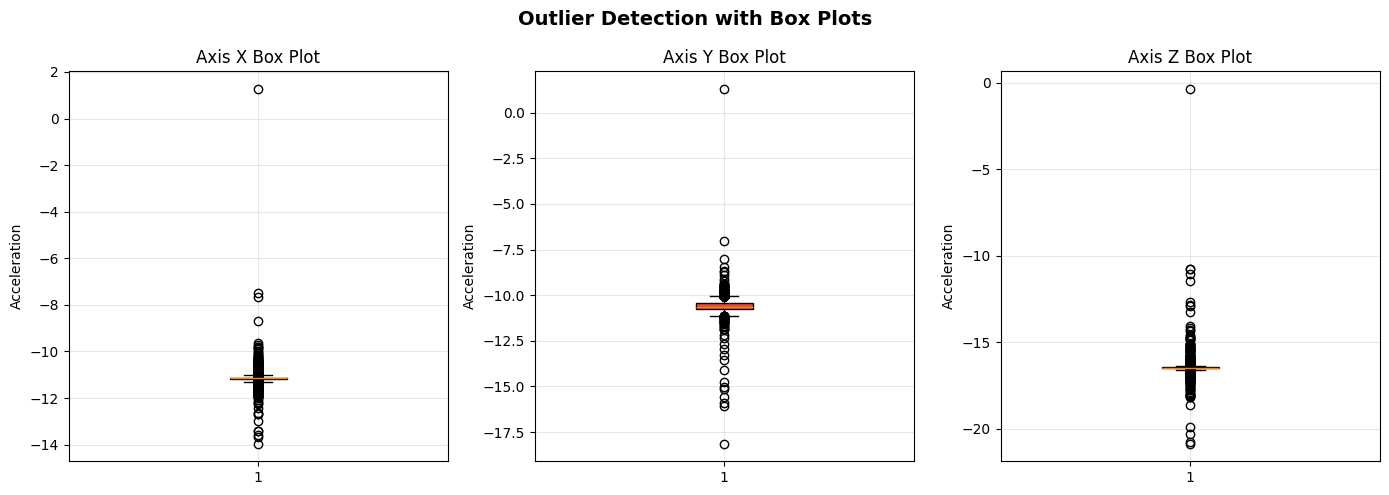

In [16]:
# EDA Step 6: Box Plots for Outlier Detection
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
colors = ['#2ecc71', '#e74c3c', '#3498db']

for i, (ax, color) in enumerate(zip(axes, colors)):
    if all_signals[0].shape[1] > i:
        bp = ax.boxplot(all_signals[0][:, i], patch_artist=True)
        bp['boxes'][0].set_facecolor(color)
        ax.set_title(f'Axis {["X", "Y", "Z"][i]} Box Plot', fontsize=12)
        ax.set_ylabel('Acceleration')
        ax.grid(True, alpha=0.3)

plt.suptitle('Outlier Detection with Box Plots', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
# EDA Step 7: Skewness and Kurtosis
from scipy.stats import skew, kurtosis

print('SKEWNESS AND KURTOSIS ANALYSIS')
print('='*50)
for i, axis in enumerate(['X', 'Y', 'Z']):
    if all_signals[0].shape[1] > i:
        s = skew(all_signals[0][:, i])
        k = kurtosis(all_signals[0][:, i])
        print(f'{axis}-axis: Skewness = {s:.4f}, Kurtosis = {k:.4f}')

SKEWNESS AND KURTOSIS ANALYSIS
X-axis: Skewness = 36.2360, Kurtosis = 6393.9761
Y-axis: Skewness = 1.0976, Kurtosis = 28.6457
Z-axis: Skewness = 45.8878, Kurtosis = 7849.4799


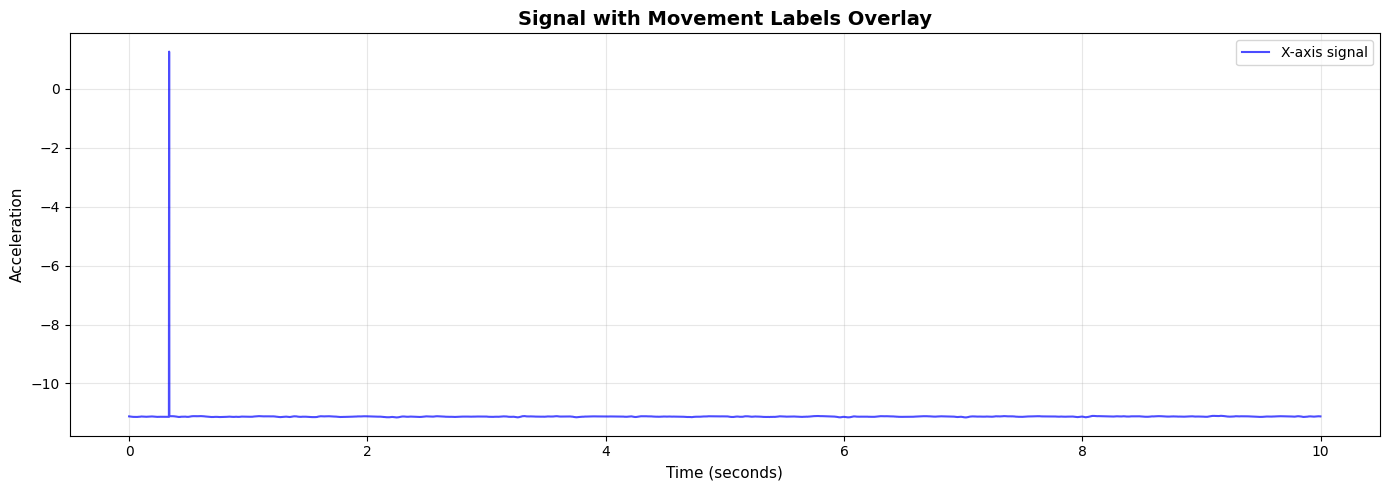

In [19]:
# EDA Step 8: Signal with Movement Labels Overlay
sample_len = 5000
time = np.arange(sample_len) / 500

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time, all_signals[0][:sample_len, 0], 'b-', alpha=0.7, label='X-axis signal')

# Overlay movement markers
bp_flat = all_labels[0].flatten()[:sample_len]
movement_times = time[bp_flat > 0]
if len(movement_times) > 0:
    for t in movement_times:
        ax.axvline(x=t, color='red', alpha=0.3, linewidth=0.5)
    ax.axvline(x=movement_times[0], color='red', alpha=0.5, label='Movement detected')

ax.set_xlabel('Time (seconds)', fontsize=11)
ax.set_ylabel('Acceleration', fontsize=11)
ax.set_title('Signal with Movement Labels Overlay', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

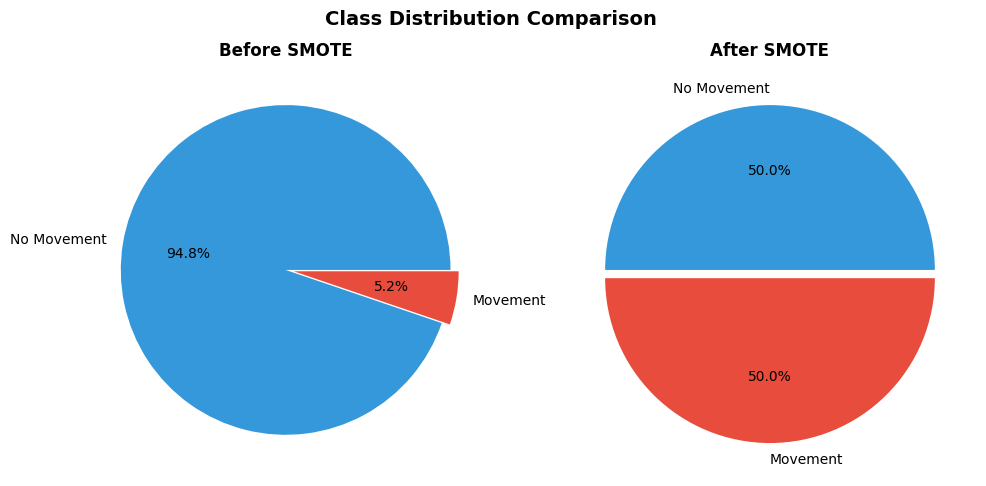

In [20]:
# EDA Step 9: Class Distribution After Balancing
plt.figure(figsize=(10, 5))
unique_b, counts_b = np.unique(y_balanced, return_counts=True)

plt.subplot(1, 2, 1)
plt.pie(counts, labels=['No Movement', 'Movement'], autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c'], explode=[0, 0.05])
plt.title('Before SMOTE', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts_b, labels=['No Movement', 'Movement'], autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c'], explode=[0, 0.05])
plt.title('After SMOTE', fontsize=12, fontweight='bold')

plt.suptitle('Class Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

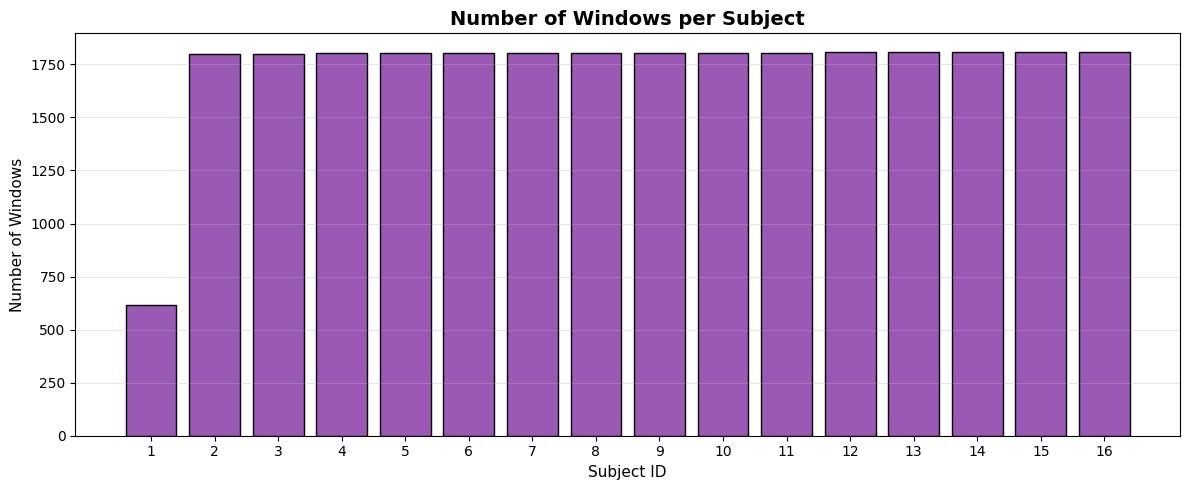

In [21]:
# EDA Step 10: Per-Subject Sample Count
subject_counts = [len(y_s) for y_s in y_all]

plt.figure(figsize=(12, 5))
plt.bar(range(1, len(subject_counts)+1), subject_counts, color='#9b59b6', edgecolor='black')
plt.xlabel('Subject ID', fontsize=11)
plt.ylabel('Number of Windows', fontsize=11)
plt.title('Number of Windows per Subject', fontsize=14, fontweight='bold')
plt.xticks(range(1, len(subject_counts)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Data Preprocessing

In [22]:
# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

print('Data normalization complete!')
print(f'Mean after scaling: {X_scaled.mean():.6f}')
print(f'Std after scaling: {X_scaled.std():.6f}')

Data normalization complete!
Mean after scaling: -0.000000
Std after scaling: 1.000000


In [23]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print('Train-Test Split Complete!')
print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTraining class distribution:')
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
for u, c in zip(unique_tr, counts_tr):
    print(f'  Class {u}: {c} ({c/len(y_train)*100:.1f}%)')

Train-Test Split Complete!
Training set: 41974 samples
Test set: 10494 samples

Training class distribution:
  Class 0: 20987 (50.0%)
  Class 1: 20987 (50.0%)


## 8. Machine Learning Baseline - Random Forest

In [24]:
# Train Random Forest Classifier
print('Training Random Forest Classifier...')
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print('Random Forest training complete!')

Training Random Forest Classifier...
Random Forest training complete!


In [25]:
# Random Forest Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print('Predictions complete!')

Predictions complete!


In [26]:
# Random Forest - Classification Report
print('='*50)
print('RANDOM FOREST - CLASSIFICATION REPORT')
print('='*50)
print(classification_report(y_test, y_pred_rf, target_names=['No Movement', 'Movement']))

RANDOM FOREST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

 No Movement       0.99      0.94      0.96      5247
    Movement       0.94      0.99      0.97      5247

    accuracy                           0.97     10494
   macro avg       0.97      0.97      0.97     10494
weighted avg       0.97      0.97      0.97     10494



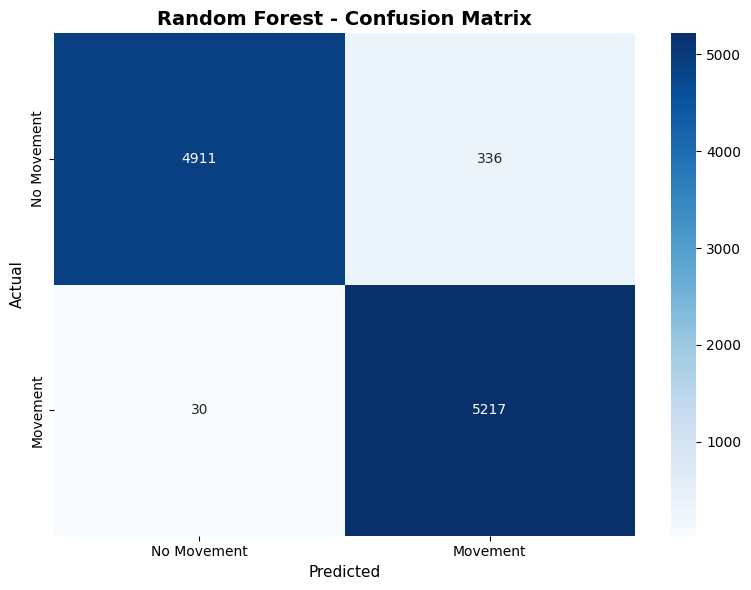

In [27]:
# Random Forest - Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Movement', 'Movement'],
            yticklabels=['No Movement', 'Movement'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.tight_layout()
plt.show()

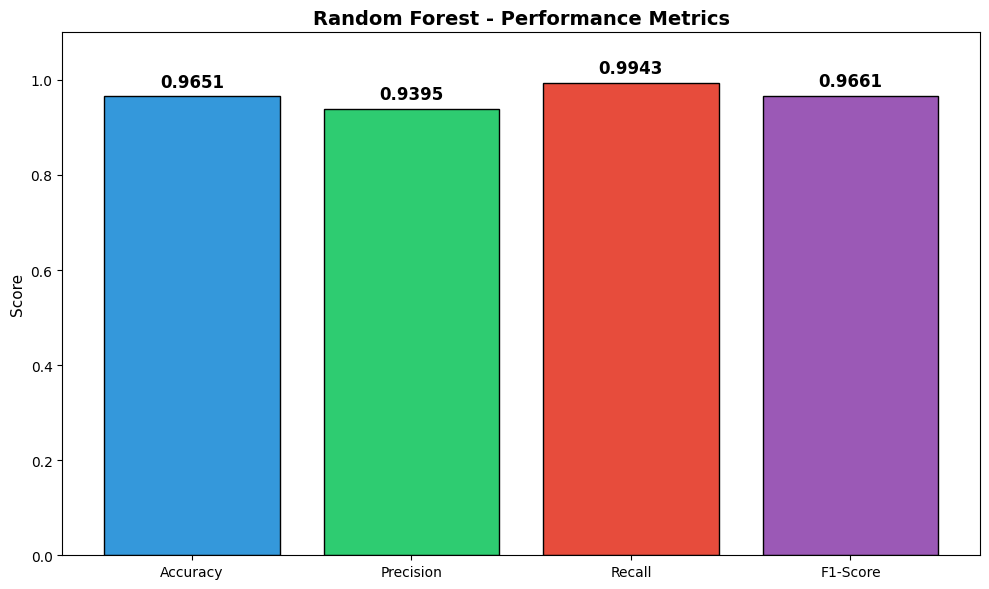

Accuracy: 0.9651
Precision: 0.9395
Recall: 0.9943
F1-Score: 0.9661


In [28]:
# Random Forest - Metrics Bar Chart
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [rf_accuracy, rf_precision, rf_recall, rf_f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black')
plt.ylim(0, 1.1)
plt.title('Random Forest - Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=11)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Accuracy: {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F1-Score: {rf_f1:.4f}')

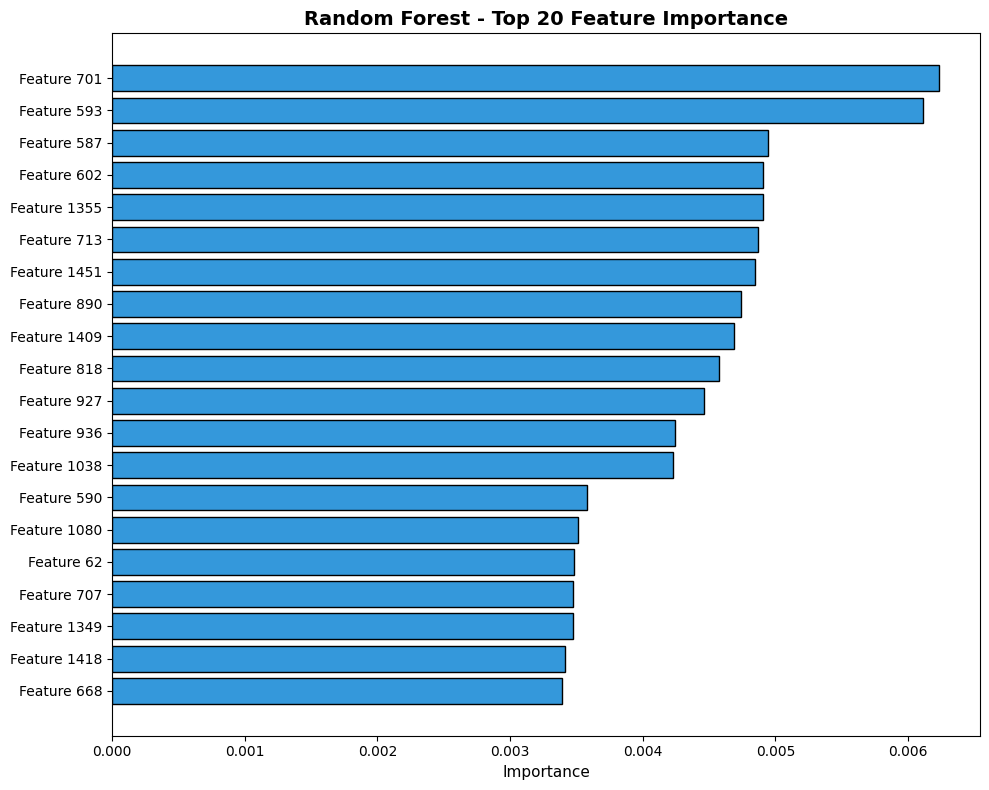

In [29]:
# Random Forest - Feature Importance (Top 20)
feature_importance = rf_model.feature_importances_
top_n = min(20, len(feature_importance))
indices = np.argsort(feature_importance)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importance[indices], color='#3498db', edgecolor='black')
plt.yticks(range(top_n), [f'Feature {i}' for i in indices])
plt.xlabel('Importance', fontsize=11)
plt.title('Random Forest - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Deep Learning Model - BiLSTM

In [30]:
# Reshape data for LSTM (samples, timesteps, features)
# Reshape back to window format
n_features = X.shape[2] if len(X.shape) == 3 else 3
X_train_lstm = X_train.reshape(-1, WINDOW_SIZE, n_features)
X_test_lstm = X_test.reshape(-1, WINDOW_SIZE, n_features)

print(f'LSTM Input Shape: {X_train_lstm.shape}')
print(f'  - Samples: {X_train_lstm.shape[0]}')
print(f'  - Timesteps: {X_train_lstm.shape[1]}')
print(f'  - Features: {X_train_lstm.shape[2]}')

LSTM Input Shape: (41974, 500, 3)
  - Samples: 41974
  - Timesteps: 500
  - Features: 3


In [31]:
# Build BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(WINDOW_SIZE, n_features)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 500, 128)       │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,145 (305.25 KB)

 Trainable params: 78,145 (305.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train BiLSTM Model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print('Training BiLSTM Model...')
history = model.fit(
    X_train_lstm, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
print('\nTraining complete!')

In [ ]:
# BiLSTM - Training & Validation Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
plt.title('BiLSTM - Training vs Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
plt.title('BiLSTM - Training vs Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# BiLSTM - Evaluate on Test Data
y_pred_proba_lstm = model.predict(X_test_lstm).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

print('BiLSTM Predictions complete!')

In [ ]:
# BiLSTM - Classification Report
print('='*50)
print('BiLSTM - CLASSIFICATION REPORT')
print('='*50)
print(classification_report(y_test, y_pred_lstm, target_names=['No Movement', 'Movement']))

In [ ]:
# BiLSTM - Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Movement', 'Movement'],
            yticklabels=['No Movement', 'Movement'])
plt.title('BiLSTM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
# BiLSTM - Metrics Bar Chart
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm)
lstm_recall = recall_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black')
plt.ylim(0, 1.1)
plt.title('BiLSTM - Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=11)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Accuracy: {lstm_accuracy:.4f}')
print(f'Precision: {lstm_precision:.4f}')
print(f'Recall: {lstm_recall:.4f}')
print(f'F1-Score: {lstm_f1:.4f}')

In [ ]:
# BiLSTM - ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'BiLSTM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('BiLSTM - ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'AUC Score: {roc_auc:.4f}')

In [ ]:
# BiLSTM - Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_lstm)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, 'g-', linewidth=2)
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('BiLSTM - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Model Comparison

In [ ]:
# Compare Random Forest vs BiLSTM
print('='*60)
print('MODEL COMPARISON: Random Forest vs BiLSTM')
print('='*60)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'BiLSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]
})
print(comparison_df.to_string(index=False))

# Comparison Bar Chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, [rf_accuracy, rf_precision, rf_recall, rf_f1], width, label='Random Forest', color='#3498db')
bars2 = ax.bar(x + width/2, [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1], width, label='BiLSTM', color='#e74c3c')

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Model Comparison: Random Forest vs BiLSTM', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Conclusion

This notebook demonstrated a complete fetal movement detection pipeline:

1. **Data Loading**: Successfully loaded accelerometer data from .mat files
2. **EDA**: Explored signal characteristics, distributions, and correlations
3. **Preprocessing**: Applied normalization and sliding window segmentation
4. **ML Baseline**: Random Forest classifier as baseline model
5. **Deep Learning**: BiLSTM model for sequential pattern recognition

Both models were evaluated using accuracy, precision, recall, F1-score, confusion matrix, and ROC curves.